In [1]:
import tensorflow as tf
import numpy as np
import cv2
import os
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split  

In [2]:
physical_devices = tf.config.experimental.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Constants

In [3]:
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128
EPOCHS = 30
TEST_DIR_HD = "test/hot_dog"
TEST_DIR_NHD = "test/not_hot_dog"
TRAIN_DIR_HD = "train/hot_dog"
TRAIN_DIR_NHD = "train/not_hot_dog"
DROPOUT = 0.25

In [4]:
# given a directory containing images, will resize the images and store as a numpy array
def image_to_array(dir, ext='.jpg'):
  data = []
  files = os.listdir(dir)
  files.sort()
  for filename in files:
    if filename.endswith(ext):
      img = cv2.imread(dir + '/' + filename)
      img = cv2.resize(img, (IMAGE_WIDTH, IMAGE_HEIGHT))
      data.append(img)

  return np.array(data)

## Data Pre-processing

In [5]:
# Normalize image pixels to values between 0-1
train_hd = image_to_array(TRAIN_DIR_HD) / 255
train_nhd = image_to_array(TRAIN_DIR_NHD) / 255
test_hd = image_to_array(TEST_DIR_HD) / 255
test_nhd = image_to_array(TEST_DIR_NHD) / 255

In [6]:
# Creating training and testing sets
X_train = np.concatenate((train_hd, train_nhd), axis=0).astype("float32")
y_train = np.concatenate((np.ones(train_hd.shape[0]), np.zeros(train_nhd.shape[0])), axis=0).astype("float32")

X_train, x_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)

x_test = np.concatenate((test_hd, test_nhd), axis=0).astype("float32")
y_test = np.concatenate((np.ones(test_hd.shape[0]), np.zeros(test_nhd.shape[0])), axis=0).astype("float32")
X_train[0].shape

(128, 128, 3)

In [7]:
img_gen_train = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.2,1.0],
    rotation_range=45
)
img_gen_train.fit(X_train)

## Build Model

In [8]:
model_input = tf.keras.Input(shape=X_train[0].shape)
base_model = tf.keras.applications.VGG16(include_top=False, input_tensor=model_input)
base_model.trainable = False
model = base_model.layers[-1].output
x = Flatten()(model)
print(x.shape)
# x = Dense(2048, activation="relu")(x)
# x = Dropout(DROPOUT)(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(DROPOUT)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(DROPOUT)(x)
out = Dense(1, activation="sigmoid")(x)
model = tf.keras.Model(inputs=model_input, outputs=out)

(None, 8192)


In [9]:
opt = tf.keras.optimizers.Adam(learning_rate=0.05)
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

## Train Model

In [10]:
hist = model.fit(X_train, y_train, batch_size=64, epochs=EPOCHS, validation_data=(x_val, y_val), verbose=1)
# hist = model.fit(img_gen_train.flow(X_train, y_train, batch_size=32), steps_per_epoch=len(X_train) / 32, epochs=EPOCHS, validation_data=(x_test, y_test), verbose=1)

Epoch 1/30
10/10 [==============================] - 10s 465ms/step - loss: 891.3426 - accuracy: 0.5274 - val_loss: 14.1794 - val_accuracy: 0.4581
Epoch 2/30
10/10 [==============================] - 1s 83ms/step - loss: 7.2073 - accuracy: 0.4916 - val_loss: 0.6849 - val_accuracy: 0.5911
Epoch 3/30
10/10 [==============================] - 1s 83ms/step - loss: 1.6601 - accuracy: 0.5505 - val_loss: 0.6005 - val_accuracy: 0.7291
Epoch 4/30
10/10 [==============================] - 1s 83ms/step - loss: 0.7303 - accuracy: 0.6090 - val_loss: 0.5758 - val_accuracy: 0.7340
Epoch 5/30
10/10 [==============================] - 1s 84ms/step - loss: 0.5682 - accuracy: 0.7110 - val_loss: 0.4780 - val_accuracy: 0.7586
Epoch 6/30
10/10 [==============================] - 1s 84ms/step - loss: 0.4799 - accuracy: 0.7733 - val_loss: 0.5166 - val_accuracy: 0.7783
Epoch 7/30
10/10 [==============================] - 1s 83ms/step - loss: 0.4239 - accuracy: 0.7882 - val_loss: 0.4912 - val_accuracy: 0.7931
Epoch 8/

## Learning Curve

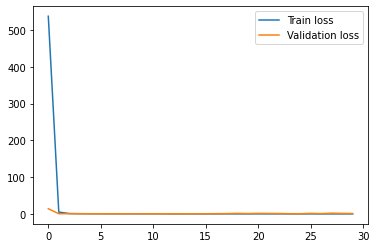

In [11]:
plt.plot(hist.history["loss"], label="Train loss")
plt.plot(hist.history["val_loss"], label="Validation loss")
plt.legend()

## Making Predictions

In [12]:
predictions = model.predict(x_test)
predictions[predictions >= 0.5] = 1
predictions[predictions < 0.5] = 0
errors = np.sum(y_test != predictions.flatten())
classification_acc = 1 - (errors / len(y_test))
cm = confusion_matrix(y_test, predictions)
print("Confusion Matrix:")
print(cm)
print(f'Total number of errors: {errors}')
print(f'The classification accuracy for the model is: {round(classification_acc,3) * 100} %')

Confusion Matrix:
[[85  9]
 [19 75]]
Total number of errors: 28
The classification accuracy for the model is: 85.1 %


## Save the model

In [13]:
# model.save("hotdog.h5")